In [1]:
from analysis_fns import performance, anova, learning_rates_per_width
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
def boxplot_factors_measure(data, factors, measure):
    ax=sns.boxplot(data=data, x=factors[0], y=measure, hue=factors[1], notch=True, showcaps=False, palette="Set2")
    sns.stripplot(data=data, x=factors[0], y=measure, hue=factors[1], palette="Set2", dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title='Phase', bbox_to_anchor=(1, 1.02), loc='upper left')
    plt.tight_layout()
    plt.show()

In [3]:
pickle_folder='../pickles'

# Pre-Post Analysis 

### Get Data

In [4]:
# return performance in terms of ICF and Jerk 
results_per_metrics = performance(pickle_folder=pickle_folder, 
                                  phases=['D1-1.0-800-Pre', 'D1-1.0-800-Post'],
                                  metrics=['icf', 'jerk', 'mvt_time'], 
                                  bounds=[0.0, 0.90])

dict_keys(['D1-1.0-800-Pre', 'D1-1.0-800-Post', 'D2-0.7-800-Tsf', 'D2-0.7-600-Tsf', 'D2-0.7-400-Tsf', 'D2-1.0-800-Ret', 'D2-1.0-600-Tsf', 'D2-1.0-400-Tsf'])


#### Metrics 1: ICF

In [5]:
data = pd.DataFrame(results_per_metrics['icf'])

In [6]:
print(data.keys())
print(len(data))

Index(['phase', 'schedule', 'icf'], dtype='object')
216


Plots and ANOVA

In [7]:
factors=['schedule', 'phase'] 

First we do an ANOVA with factors `schedule` and `phase` to see if they have an impact on `ICF`

In [8]:
print(anova(data, factors=factors, measure='icf'))

                        sum_sq     df          F        PR(>F)
C(schedule)           0.011765    2.0   0.510987  6.006473e-01
C(phase)              0.957932    1.0  83.210315  6.137531e-17
C(schedule):C(phase)  0.059412    2.0   2.580405  7.814350e-02
Residual              2.417557  210.0        NaN           NaN
None


*Result* : there is no impact of `schedule` but there is an impact of `phase` (people learn something in terms of ICF)

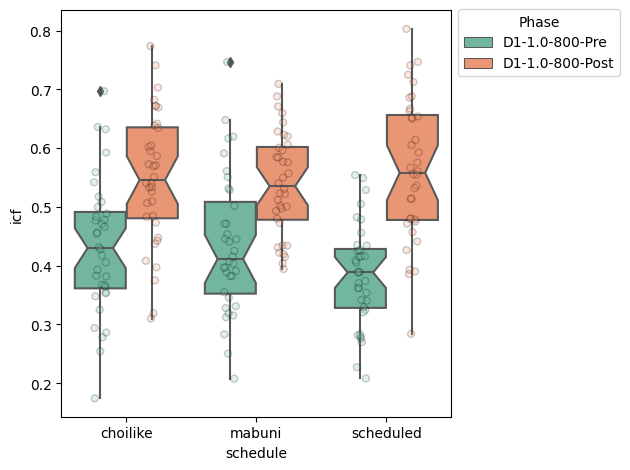

In [9]:
boxplot_factors_measure(data, factors, 'icf')

In [10]:
data2 = data[data['phase'] == 'D1-1.0-800-Pre']
print(anova(data2, factors=['schedule'], measure='icf'))

               sum_sq     df         F    PR(>F)
C(schedule)  0.060476    2.0  2.649202  0.075432
Residual     1.198475  105.0       NaN       NaN
None


#### Metrics 2: JERK

In [11]:
data = pd.DataFrame(results_per_metrics['jerk'])

Same analysis than before: ANOVA with factors `schedule` and `phase` to see if they have an impact on `Jerk`

In [12]:
anova(data, factors=factors, measure='jerk')

                            sum_sq     df           F        PR(>F)
C(schedule)           2.608025e+05    2.0    4.596130  1.112700e-02
C(phase)              6.432090e+06    1.0  226.705812  3.118767e-35
C(schedule):C(phase)  5.015888e+04    2.0    0.883951  4.146786e-01
Residual              5.958113e+06  210.0         NaN           NaN


*Results*: Both factors have a significant impact, lets look graphically:

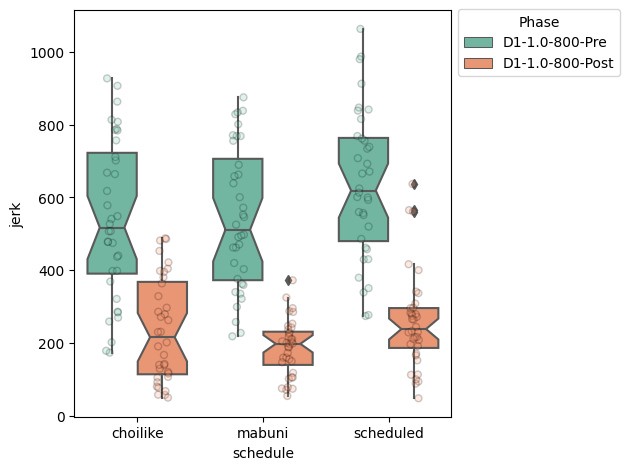

In [13]:
boxplot_factors_measure(data, factors, 'jerk')

Graphically we see that Jerk is lower at postest (people learn something in terms of Jerk) and Jerk seems lower for MAB at posttest. Let's check with a one-way ANOVA:

In [14]:
data2  = data[data['phase'] == 'D1-1.0-800-Post']
anova(data2, factors=['schedule'], measure='jerk')

                   sum_sq     df         F    PR(>F)
C(schedule)  9.465153e+04    2.0  3.268462  0.041972
Residual     1.520350e+06  105.0       NaN       NaN


`Schedule` has indeed a significant impact on `Jerk`, we can do a post-hoc analysis to see which ones are different (using pairwise t-test):

In [15]:
from scipy.stats import ttest_ind
print('MAB vs RANDOM', ttest_ind(data2[data2['schedule'] == 'mabuni']['jerk'],
        data2[data2['schedule'] == 'scheduled']['jerk']))
print('CHOI vs RANDOM',ttest_ind(data2[data2['schedule'] == 'choilike']['jerk'],
        data2[data2['schedule'] == 'scheduled']['jerk']))
print('CHOI vs MAB',ttest_ind(data2[data2['schedule'] == 'choilike']['jerk'],
        data2[data2['schedule'] == 'mabuni']['jerk']))

MAB vs RANDOM Ttest_indResult(statistic=-2.7923197906957697, pvalue=0.006742074177793271)
CHOI vs RANDOM Ttest_indResult(statistic=-0.6888103516351113, pvalue=0.49321936675645317)
CHOI vs MAB Ttest_indResult(statistic=1.8078501903663997, pvalue=0.07492580466562153)


*Result* : `MAB` leads to lower Jerk compared to `RANDOM` and `CHOI`, there is no difference between `CHOI` and `RANDOM`

### Learning Rates (analysed per width)

We inspect learning rates now, although I realise that we should analyse per width as a general learning rate computed across tasks (so widths) may not make sense. At least we have to see if the width affects the learning rates. If it doesn't we can look at the aggregated learning rates across widths. 

In [16]:
rates = learning_rates_per_width(pickle_folder=pickle_folder,
               metrics=['icf', 'jerk'],
               bounds=[0., 0.98])

In [17]:
df_rates = pd.DataFrame(rates)

#### Metrics 1: ICF

Similarly than before, first we look at `ICF`

<AxesSubplot:xlabel='schedule', ylabel='icf'>

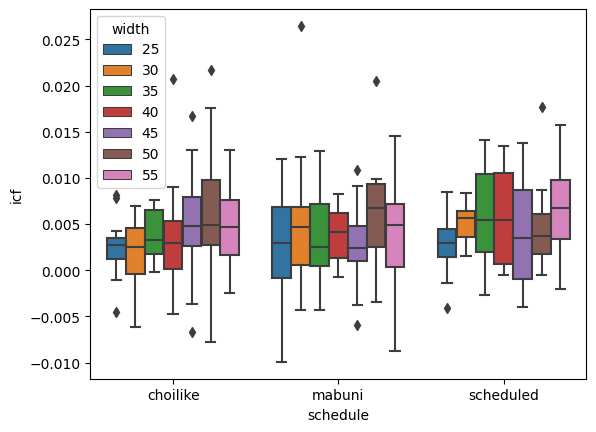

In [18]:
sns.boxplot(data=df_rates, x='schedule', hue='width', y='icf')

We look at the influence of `wdith` and `schedule` on `ICF` with a two-way ANOVA

In [19]:
anova(df_rates, factors=['width', 'schedule'], measure='icf')

                        sum_sq     df         F    PR(>F)
C(width)              0.000223    6.0  1.256418  0.278561
C(schedule)           0.000055    2.0  0.934159  0.394396
C(width):C(schedule)  0.000212   12.0  0.597103  0.843571
Residual              0.006820  231.0       NaN       NaN


*Results*: No significant difference.

#### Metrics 2: JERK

<AxesSubplot:xlabel='schedule', ylabel='jerk'>

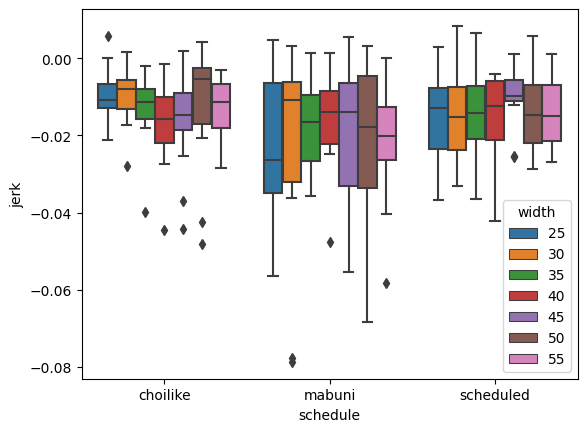

In [20]:
sns.boxplot(data=df_rates, x='schedule', hue='width', y='jerk')

Same analysis with `Jerk`...

In [21]:
anova(df_rates, factors=['width', 'schedule'], measure='jerk')

                        sum_sq     df         F    PR(>F)
C(width)              0.000120    6.0  0.093817  0.996924
C(schedule)           0.002848    2.0  6.672918  0.001523
C(width):C(schedule)  0.001432   12.0  0.559126  0.873306
Residual              0.049299  231.0       NaN       NaN


The two-way ANOVA above shows that there is no significant influence of width but there is of schedule, therefore we can aggregate data along the width and do a one-way anova with factor `schedule`

In [22]:
anova(df_rates, factors=['schedule'], measure='jerk')

               sum_sq     df         F    PR(>F)
C(schedule)  0.002848    2.0  6.973349  0.001131
Residual     0.050851  249.0       NaN       NaN


The ANOVA shows a significant effect of `schedule`, so we can do post-how analysis: basically pairwise T-Tests ...

In [23]:
from scipy.stats import ttest_ind
print('MAB vs RANDOM', ttest_ind(df_rates[df_rates['schedule'] == 'mabuni']['jerk'],
        df_rates[df_rates['schedule'] == 'scheduled']['jerk']))
print('CHOI vs RANDOM',ttest_ind(df_rates[df_rates['schedule'] == 'choilike']['jerk'],
        df_rates[df_rates['schedule'] == 'scheduled']['jerk']))
print('CHOI vs MAB',ttest_ind(df_rates[df_rates['schedule'] == 'choilike']['jerk'],
        df_rates[df_rates['schedule'] == 'mabuni']['jerk']))

MAB vs RANDOM Ttest_indResult(statistic=-2.861333436323076, pvalue=0.004761695979477344)
CHOI vs RANDOM Ttest_indResult(statistic=0.2633151570094376, pvalue=0.7926342349933243)
CHOI vs MAB Ttest_indResult(statistic=3.0378670972517403, pvalue=0.00276810233325971)


`MAB` is significant lower than `CHOI` and `RANDOM` meaning that people learn **faster** with MAB

# All Phases

In [24]:
phases = ['D1-1.0-800-Pre', 
          'D1-1.0-800-Post', 
          'D2-1.0-800-Ret', 
                'D2-1.0-600-Tsf', 
                'D2-1.0-400-Tsf', 
                'D2-0.7-800-Tsf',
                'D2-0.7-600-Tsf',
                'D2-0.7-400-Tsf']

In [25]:
results_per_metrics = performance(pickle_folder=pickle_folder, 
                                  phases=phases,
                                  metrics=['icf', 'jerk', 'mvt_time'], 
                                  bounds=[0.0, 0.98])

dict_keys(['D1-1.0-800-Pre', 'D1-1.0-800-Post', 'D2-0.7-800-Tsf', 'D2-0.7-600-Tsf', 'D2-0.7-400-Tsf', 'D2-1.0-800-Ret', 'D2-1.0-600-Tsf', 'D2-1.0-400-Tsf'])


In [26]:
factors = ['schedule', 'phase']

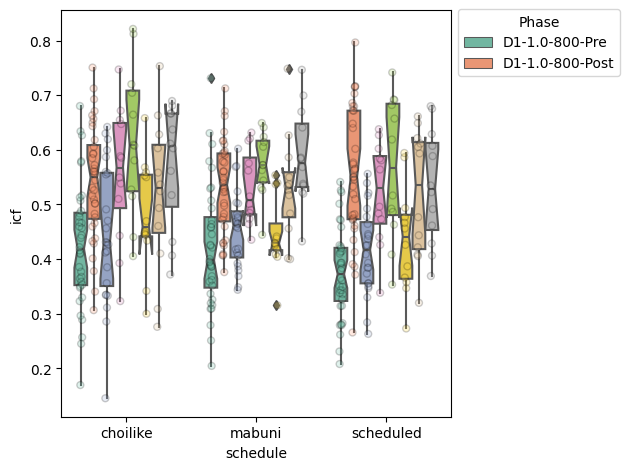

In [27]:
data = pd.DataFrame(results_per_metrics['icf'])
boxplot_factors_measure(data, factors, 'icf')

In [28]:
anova(data, factors=factors, measure='icf')

                        sum_sq     df          F        PR(>F)
C(schedule)           0.056405    2.0   2.659099  7.112619e-02
C(phase)              1.903762    7.0  25.642486  1.899709e-29
C(schedule):C(phase)  0.088808   14.0   0.598091  8.670699e-01
Residual              4.709096  444.0        NaN           NaN


In [29]:
for phase in phases:
    # if 'Ret' in phase or 'Tsf' in phase:
    data2 = data[data['phase'] == phase]
    print('**', phase)
    anova(data2, factors=['schedule'], measure='icf')

** D1-1.0-800-Pre
               sum_sq     df         F    PR(>F)
C(schedule)  0.055947    2.0  2.593034  0.079577
Residual     1.132730  105.0       NaN       NaN
** D1-1.0-800-Post
               sum_sq     df         F   PR(>F)
C(schedule)  0.010116    2.0  0.462698  0.63086
Residual     1.147828  105.0       NaN      NaN
** D2-1.0-800-Ret
               sum_sq    df         F    PR(>F)
C(schedule)  0.020824   2.0  1.154224  0.321314
Residual     0.622423  69.0       NaN       NaN
** D2-1.0-600-Tsf
               sum_sq    df         F    PR(>F)
C(schedule)  0.006996   2.0  0.371713  0.692402
Residual     0.310553  33.0       NaN       NaN
** D2-1.0-400-Tsf
               sum_sq    df         F    PR(>F)
C(schedule)  0.017928   2.0  0.712381  0.497862
Residual     0.415242  33.0       NaN       NaN
** D2-0.7-800-Tsf
               sum_sq    df         F    PR(>F)
C(schedule)  0.013777   2.0  0.855884  0.434124
Residual     0.265593  33.0       NaN       NaN
** D2-0.7-600-Tsf
      

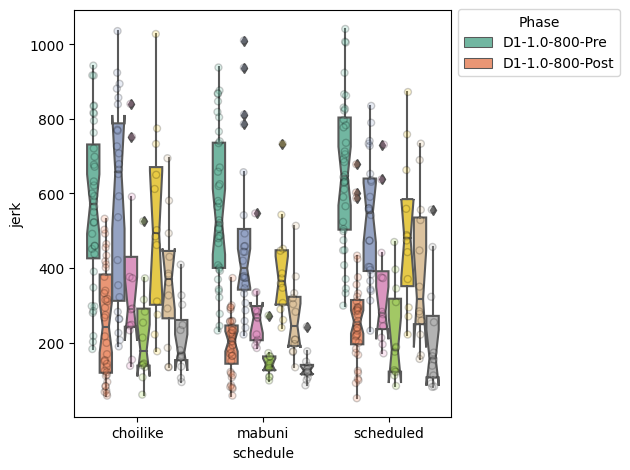

In [30]:
data = pd.DataFrame(results_per_metrics['jerk'])
boxplot_factors_measure(data, ['schedule', 'phase'], 'jerk')

In [31]:
anova(data, factors=factors, measure='jerk')

                            sum_sq     df          F        PR(>F)
C(schedule)           6.080126e+05    2.0   9.998350  5.658655e-05
C(phase)              1.160352e+07    7.0  54.517694  5.176003e-56
C(schedule):C(phase)  2.330769e+05   14.0   0.547541  9.042463e-01
Residual              1.350011e+07  444.0        NaN           NaN


In [32]:
for phase in phases:
    if 'Ret' in phase or 'Tsf' in phase:
        data2 = data[data['phase'] == phase]
        print('**', phase)
        anova(data2, factors=['schedule'], measure='jerk')

** D1-1.0-800-Pre
                   sum_sq     df         F    PR(>F)
C(schedule)  2.088963e+05    2.0  2.472261  0.089294
Residual     4.436043e+06  105.0       NaN       NaN
** D1-1.0-800-Post
                   sum_sq     df         F    PR(>F)
C(schedule)  1.174102e+05    2.0  3.687239  0.028339
Residual     1.671721e+06  105.0       NaN       NaN
** D2-1.0-800-Ret
                   sum_sq    df         F    PR(>F)
C(schedule)  1.570909e+05   2.0  1.614637  0.206389
Residual     3.356567e+06  69.0       NaN       NaN
** D2-1.0-600-Tsf
                   sum_sq    df         F    PR(>F)
C(schedule)  6.427126e+04   2.0  1.032649  0.367283
Residual     1.026947e+06  33.0       NaN       NaN
** D2-1.0-400-Tsf
                    sum_sq    df         F   PR(>F)
C(schedule)   43620.716793   2.0  1.813383  0.17898
Residual     396905.626656  33.0       NaN      NaN
** D2-0.7-800-Tsf
                   sum_sq    df         F   PR(>F)
C(schedule)  1.027467e+05   2.0  1.260998  0.29667
Res